In [1]:
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math as mt
import scipy


In [2]:
import pandas as pd 

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pharmacokinetics-of-indomethacin/Indometh.csv


In [3]:
df = pd.read_csv('../input/pharmacokinetics-of-indomethacin/Indometh.csv', nrows = None, index_col=0)
df.dataframeName = 'Indometh.csv'
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 66 rows and 3 columns


In [4]:
df.head(5)

,Subject,time,conc
1,1,0.25,1.50
2,1,0.50,0.94
3,1,0.75,0.78
4,1,1.00,0.48
5,1,1.25,0.37


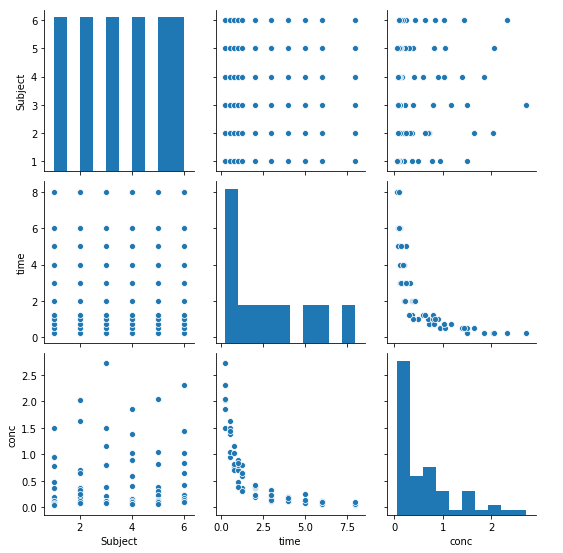

In [5]:
# Plot all variable combinations
sns.pairplot(df)

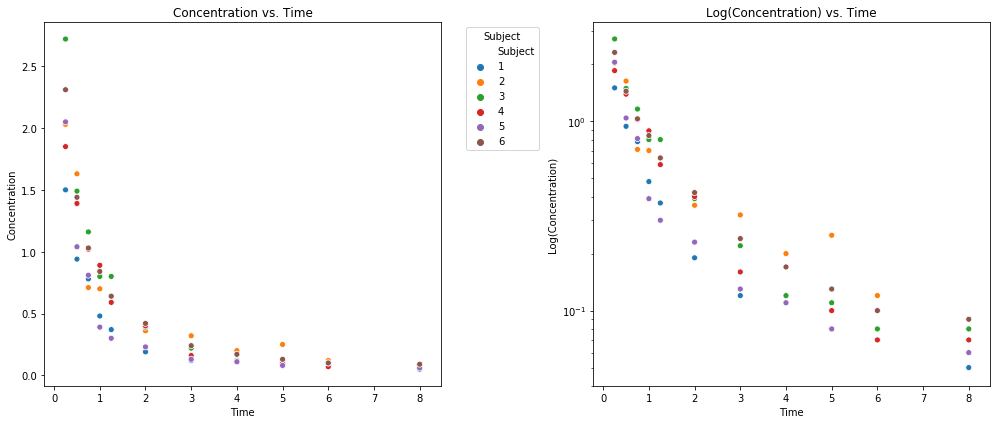

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# Plot 1: Linear scale concentration vs. time
sns.scatterplot(x="time", y="conc", hue="Subject", data=df, palette="tab10", ax=axes[0])
axes[0].set_title("Concentration vs. Time")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Concentration")
axes[0].legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 2: Log-transformed concentration vs. time
sns.scatterplot(x="time", y="conc", hue="Subject", data=df, palette="tab10", ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_title("Log(Concentration) vs. Time")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Log(Concentration)")
axes[1].legend([],[], frameon=False)  

# Adjust layout
plt.tight_layout()
plt.show()
# This dataset likely contains plasma concentrations of Indemethacin (NSAID) from 6 participants
# collected at 11 time points. Most likely after IV administration. 


In [7]:
# Non-Compartmental Analysis
# Since it is IV, I will not compute Cmax and Tmax
# I do not know the dose administered, therefore I cannot estimate Vd and CL
# I will estimate halflife and Kel
from scipy.stats import linregress

def compute_kel(conc,time):
     # Fit a linear regression on the log-transformed concentrations to estimate kel
    log_conc = np.log(conc)
    slope, _, _, _, _ = linregress(time, log_conc)
    return -slope

def compute_half_life(conc,time):
    kel = compute_kel(conc,time)
    return np.log(2) / kel

kel = compute_kel(df['conc'], df['time'])
half_life = compute_half_life(df['conc'], df['time'])

print(f"Kel: {kel:.4f}, Half-life: {half_life:.2f} hours")
    

Kel: 0.4191, Half-life: 1.65 hours


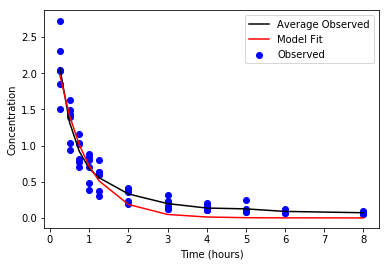

Fitted parameters: C0 = 2.78, kel = 1.3504


In [8]:
# One-Compartmental model with first-order elimination
from scipy.optimize import curve_fit

def one_compartment_model(t, C0, kel):
    return C0 * np.exp(-kel * t)

params, _ = curve_fit(one_compartment_model, df['time'], df['conc'], p0=[50, 0.1])
C0, kel = params

df_avg = df.groupby("time")["conc"].mean().reset_index()
# Plot data vs. model predictions
plt.scatter(df['time'], df['conc'], label='Observed', color='blue')
plt.plot(df_avg["time"], df_avg["conc"], linestyle='-', color='k', label='Average Observed')
plt.plot(df['time'].unique(), one_compartment_model(df['time'].unique(), C0, kel), label='Model Fit', color='red')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration')
plt.legend()
plt.show()

print(f"Fitted parameters: C0 = {C0:.2f}, kel = {kel:.4f}")

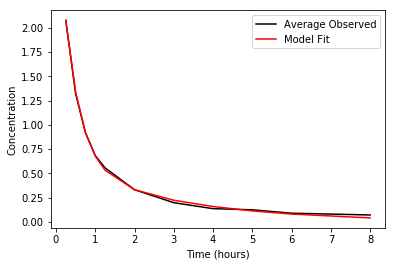

kel = 2.4262


In [9]:
# two-compartmental model
def two_compartment_model(t, A, ka, B, kel):
    return A * np.exp(-ka * t) - B * np.exp(-kel * t)


params, _ = curve_fit(two_compartment_model, df['time'], df['conc'], p0=[100, 0.1, 50, 0.5])
A, ka, B, kel = params

df_avg = df.groupby("time")["conc"].mean().reset_index()
# Plot data vs. model predictions
#plt.scatter(df['time'], df['conc'], label='Observed', color='blue')
plt.plot(df_avg["time"], df_avg["conc"], linestyle='-', color='k', label='Average Observed')
plt.plot(df['time'].unique(), two_compartment_model(df['time'].unique(), A, ka, B, kel), label='Model Fit', color='red')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration')
plt.legend()
plt.show()

print(f"kel = {kel:.4f}")

In [10]:
# Quantify the models and make overview table of kel, estimated with different methods

# Fit one-compartment model
params_1, _ = curve_fit(one_compartment_model, df['time'], df['conc'], p0=[50, 0.5])
C0_1, kel_1 = params_1

# Fit two-compartment model
params_2, _ = curve_fit(two_compartment_model, df['time'], df['conc'], p0=[100, 0.1, 50, 0.5])
A_2, ka_2, B_2, kel_2 = params_2

# Calculate NCA kel 
kel_nca = compute_kel(df['conc'],df['time'])

# Calculate AIC and BIC for model comparisons
def calculate_aic_bic(n, rss, k):
    aic = n * np.log(rss / n) + 2 * k
    bic = n * np.log(rss / n) + k * np.log(n)
    return aic, bic

# Calculate residuals and goodness-of-fit metrics
n = len(df['conc'])
rss_1 = np.sum((df['conc']- one_compartment_model(df['time'], *params_1))**2)
rss_2 = np.sum((df['conc'] - two_compartment_model(df['time'], *params_2))**2)

aic_1, bic_1 = calculate_aic_bic(n, rss_1, 2)
aic_2, bic_2 = calculate_aic_bic(n, rss_2, 4)

# Create a summary table
results = pd.DataFrame({
    'Method': ['NCA', 'One-Compartment', 'Two-Compartment'],
    'kel (hr^-1)': [kel_nca, kel_1, kel_2],
    'AIC': [np.nan, aic_1, aic_2],
    'BIC': [np.nan, bic_1, bic_2],
    'RSS': [np.nan, rss_1, rss_2]
})

display(results)

,Method,kel (hr^-1),AIC,BIC,RSS
0,NCA,0.419103,NaN,NaN,NaN
1,One-Compartment,1.350375,-210.389889,-206.010580,2.563371
2,Two-Compartment,2.426180,-226.584332,-217.825714,1.887676


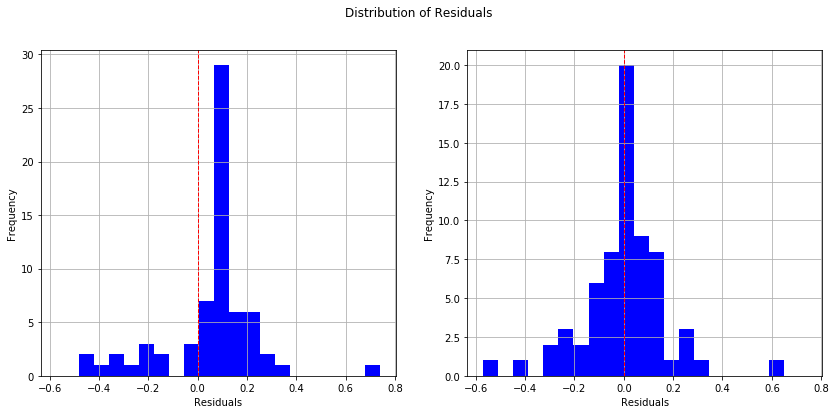

In [11]:
# Visualize residuals for one and two compartmental models
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

y_pred_1 = one_compartment_model(df['time'], *params_1)
y_pred_2 = two_compartment_model(df['time'], *params_2)

residuals1 = df['conc'] - y_pred_1
residuals2 = df['conc'] - y_pred_2

axes[0].hist(residuals1, color='blue', label='Model 1 Residuals', bins=20)
axes[1].hist(residuals2, color='blue', label='Model 2 Residuals', bins=20)
for ax in axes:
    ax.axvline(0, color='red', linestyle='--', linewidth=1)
    ax.set_xlabel('Residuals')
    ax.set_ylabel('Frequency')
    ax.grid(True)
fig.suptitle('Distribution of Residuals')
plt.show()

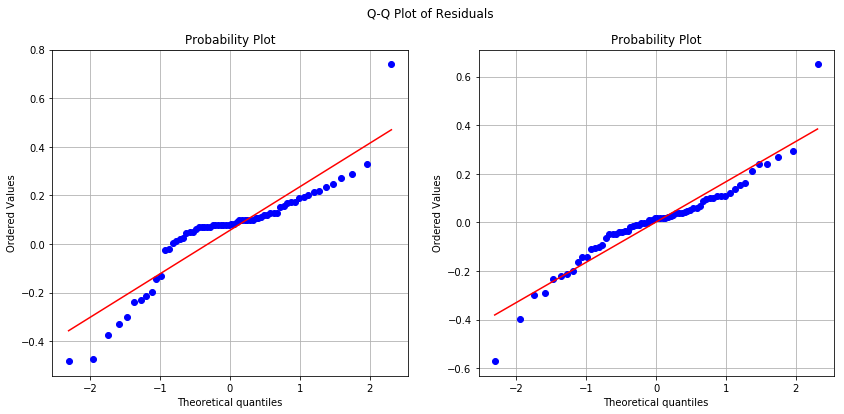

In [12]:
import scipy.stats as stats

# Quantile-Quantile plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)
stats.probplot(residuals1, dist="norm", plot=axes[0])
stats.probplot(residuals2, dist="norm", plot=axes[1])
fig.suptitle('Q-Q Plot of Residuals')
axes[0].grid(True)
axes[1].grid(True)
plt.show()

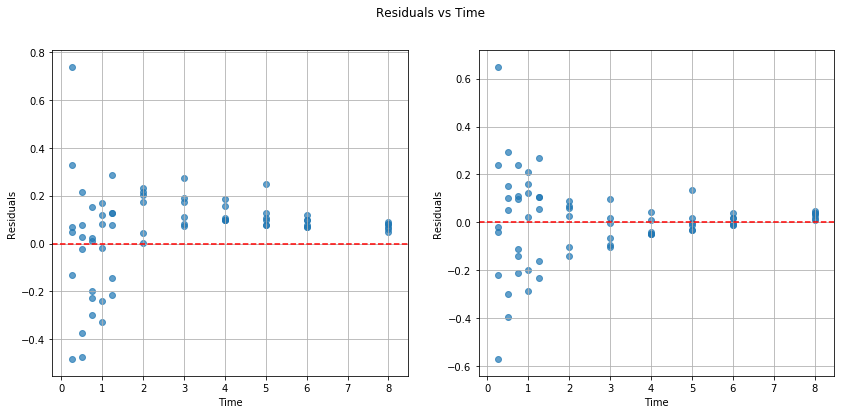

In [13]:
# Residuals vs time
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)
axes[0].scatter(df['time'], residuals1, alpha=0.7)
axes[1].scatter(df['time'], residuals2, alpha=0.7)

for ax in axes:
    ax.axhline(0, color='red', linestyle='--')
    ax.set_xlabel('Time')
    ax.set_ylabel('Residuals')
    ax.grid(True)
fig.suptitle('Residuals vs Time')
plt.show()

 AIC, BIC, RSS, and various residual analyses (Histrogram, Q-Q plot, 
 and residuals vs. time) all consistently show that the two-compartment model 
 fits the data better than the one-compartment model.
 Therefore, the drug exhibit a biphasic pattern, with a distribution phase and an 
 elimination phase. 
 The elimination constant and half-life estimated here, is very far from what have 
 previously been reported for indomethacin.
 However, I do not know the source of this data and the unit of time (I have assumed 
 hours).
 